# EP1 - Decomposição LU para Matrizes Tridiagonais
### Gabriel Souza Lima 11820106
### Lucas Pereira da Fonseca 11808126

### Bibliotecas

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

Escolha o valor de n abaixo para realizar os testes.

In [2]:
n = 20000

## Funções usadas na resolução
Rode a célula abaixo para criar as funções.

In [3]:
#criando os coeficientes da matriz tridiagonal cíclica, tal como definido no enunciado do EP.
def criaCoeficientes(n):
    """Cria os coeficientes da matriz tridiagonal cíclica e o vetor d
    Args:
        n: tamanho dos vetores
    Return:
        a, b, c e d"""
    a = (2*np.arange(1,n+1)-1)/(4*np.arange(1,n+1))
    a[n-1] = (2*n-1)/(2*n)
    c = 1 - a
    b = np.repeat(2,n)
    d = np.array([math.cos(i) for i in 2*math.pi*(np.arange(1,n+1)**2)/(n**2)])
    return a,b,c,d   

def criaVetoresTridiagonais(n):
    """Cria os coeficientes da matriz tridiagonal e o vetor d, para testar a função resolveSlTridiagonal()
    Args:
        n: tamanho dos vetores
    Return:
        a, b, c e d"""
    a = np.repeat(-1,n)
    b = np.repeat(2,n)
    c = np.copy(a)
    a[0] = 0
    c[n-1] = 0
    d = np.repeat(1,n)
    return a,b,c,d

def decompoeTridiagonalLU(a,b,c):
    """Faz a decomposição em LU de uma matriz A nxn tridiagonal, com coeficientes a, b, c.
    Args: 
        a, b, c: diagonais não nulas da matriz tridiagonal A
    Return:      
        l: multiplicadores da matriz L
        u: diagonal principal de U
    """
    n = len(a)
    u = np.zeros(n)
    l = np.zeros(n)
    u[0] = b[0]
    for i in range(1,n,1):
        l[i] = a[i]/u[i-1]
        u[i] = b[i]-l[i]*c[i-1]
    return l, u

def resolveSlTridiagonal(a,b,c,d):
    """Resolve um sistema linear tridiagonal
    Args:
        a, b, c: diagonais não nulas da matriz tridiagonal A
        d: vetor tal que Ax = d
    Return:
        x: solução do sistema linear
    """
    #gerando os vetores que representam L e U
    l, u = decompoeTridiagonalLU(a,b,c) 
    
    n = len(a)
    y = np.zeros(n)
    x = np.zeros(n)
    
    #Ly = d
    y[0] = d[0]
    for i in range(1,n,1):
        y[i] = d[i] - l[i]*y[i-1]
    
    #Ux = y
    x[n-1] = y[n-1]/u[n-1]
    for i in range(n-2,-1,-1):
        x[i] = (y[i] - c[i]*x[i+1])/u[i]
        
    return x

def resolveSistemaTridiagonalCiclico(a,b,c,d):
    """Resolve um sistema tridiagonal cíclico
    Args:
        a, b, c: diagonais não nulas da matriz tridiagonal A
        d: vetor tal que Ax = d
    Return:
        x: solução do sistema linear
    """
    n = len(a)
    
    #v = (a1,0,...,0,cn-1)T
    v = np.zeros(n-1)
    v[0], v[n-2] = a[0], c[n-2]
    v = v.T
    
    # w = (cn,0,...,0,an)T
    w = np.zeros(n-1)
    w[0], w[n-2] = c[n-1], a[n-1]
    w = w.T
    
    # d_ = (d1,...,dn-1)T
    d_ = d[:n-1].T
    
    # T é a submatriz principal de A. 
    # Representamos T pelos vetores a_sub=(0,a2,...,an-1), b_sub=(b1,...,bn-1) e c_sub(c1,...,cn-2) para economizar memória    
    a_sub = np.concatenate((np.array([0]),a[1:n-1]))
    b_sub = b[:n-1]
    c_sub = np.concatenate((c[:n-2],np.array([0])))  
    
    # Ty_ = d_ 
    y_ = resolveSlTridiagonal(a_sub, b_sub, c_sub, d_)
    
    # Tz_ = v
    z_ = resolveSlTridiagonal(a_sub, b_sub, c_sub ,v)
    
    # Aqui iremos encontrar x, a solução de Ax = d
    x = np.zeros(n).T
    x[n-1] = (d[n-1]-c[n-1]*y_[0]-a[n-1]*y_[n-2])/(b[n-1]-c[n-1]*z_[0]-a[n-1]*z_[n-2])
    x[:n-1] = y_ - x[n-1]*z_
    
    return x

def erroSlTridiagonal(a,b,c,d,x):
    """Encontra o maior erro na solução de um sistema tridiagonal
    Args:    
        a, b, c: diagonais não nulas da matriz tridiagonal A
        x: solução do sistema linear
        d: vetor tal que Ax = d      
    Return:
        maior_erro: maior erro da solução 
    """
    n = len(a)
    erro = np.zeros(n)
    erro[0] = d[0] - (b[0]*x[0]+c[0]*x[1])
    for i in range(1,n-1):
        erro[i] = d[i] - (a[i]*x[i-1]+b[i]*x[i]+c[i]*x[i+1])
    erro[n-1] = d[n-1] - (a[n-1]*x[n-2]+b[n-1]*x[n-1])
    maior_erro = np.max(np.abs(erro))
    return maior_erro

def erroSlTridiagonalCiclico(a,b,c,d,x):
    """Encontra o maior erro na solução de um sistema tridiagonal cíclico
    Args:    
        a, b, c: diagonais não nulas da matriz tridiagonal A
        x: solução do sistema linear
        d: vetor tal que Ax = d      
    Return:
        maior_erro: maior erro da solução 
    """
    n = len(a)
    erro = np.zeros(n)
    erro[0] = d[0] - (b[0]*x[0]+c[0]*x[1]+a[0]*x[n-1])
    for i in range(1,n-1):
        erro[i] = d[i] - (a[i]*x[i-1]+b[i]*x[i]+c[i]*x[i+1])
    erro[n-1] = d[n-1] - (c[n-1]*x[0]+a[n-1]*x[n-2]+b[n-1]*x[n-1])
    maior_erro = np.max(np.abs(erro))
    return maior_erro

def calculaResiduoParaGrafico(n):
    """Calcula o resíduo máximo de uma solução do sistema tridiagonal cíclico. Essa função será usada para plotar o gráfico
    Args:
        n: tamanho do vetor
    Return:
        erro_max: resíduo máximo"""
    a,b,c,d = criaCoeficientes(n)
    x = resolveSistemaTridiagonalCiclico(a,b,c,d)
    erro = np.zeros(n)
    erro[0] = d[0] - (b[0]*x[0]+c[0]*x[1]+a[0]*x[n-1])
    for i in range(1,n-1):
        erro[i] = d[i] - (a[i]*x[i-1]+b[i]*x[i]+c[i]*x[i+1])
    erro[n-1] = d[n-1] - (c[n-1]*x[0]+a[n-1]*x[n-2]+b[n-1]*x[n-1])
    erro_max = np.max(np.abs(erro))
    return erro_max

### Tarefa 1
Basta rodar as células para visualizar os resultados.

In [4]:
# gerando os coeficientes
a,b,c,d = criaCoeficientes(n)

# vamos ver quais são os vetores l e u
l, u = decompoeTridiagonalLU(a,b,c)
print(f" Vetor l: {l} \n\n Vetor u: {u} \n")

 Vetor l: [0.         0.1875     0.22408964 ... 0.26794249 0.26794249 0.53588499] 

 Vetor u: [2.         1.859375   1.85994398 ... 1.8660254  1.8660254  1.73205081] 



### Tarefa 2

In [5]:
# aqui, testamos a função resolveSlTridiagonal
inicio = time.time()
a_,b_,c_,d_ = criaVetoresTridiagonais(n)
x_ = resolveSlTridiagonal(a_,b_,c_,d_)
r_ = erroSlTridiagonal(a_,b_,c_,d_,x_)
tempo = time.time() - inicio

print(f" Solução do sistema tridiagonal: {x_} \n\n Soma da solução: {np.sum(x_)} \n\n Resíduo máximo: {r_} \n\n Duração: {tempo} s")

 Solução do sistema tridiagonal: [10000.00000027 19999.00000053 29997.0000008  ... 29997.00000006
 19999.00000004 10000.00000002] 

 Soma da solução: 666766670018.258 

 Resíduo máximo: 1.4901161193847656e-08 

 Duração: 0.5362036228179932 s


### Solução do sistema tridiagonal cíclico
Rode a célula abaixo para verificar a solução e o erro.

In [6]:
inicio  = time.time()

#criando os vetores
a,b,c,d = criaCoeficientes(n) 
#encontrando a solução
x = resolveSistemaTridiagonalCiclico(a,b,c,d)
#calculando o resíduo máximo
r = erroSlTridiagonalCiclico(a,b,c,d,x)

tempo = time.time() - inicio
print(f" Tamanho do vetor: {n} \n\n Solução: {x} \n\n Soma da solução: {np.sum(x)} \n\n Resíduo máximo: {r} \n\n Duração: {tempo} s")

 Tamanho do vetor: 20000 

 Solução: [0.33333333 0.33333333 0.33333333 ... 0.33333309 0.33333329 0.33333336] 

 Soma da solução: 1627.5113595866928 

 Resíduo máximo: 2.220446049250313e-16 

 Duração: 0.3612377643585205 s


### Finalmente, vamos visualizar qual foi o erro da solução para o sistema tridiagonal cíclico.
Se desejar, pode mudar as variáveis n_min, n_max, e step.

In [7]:
n_min = 10
n_max = 50000
step = 1000

### Gráficos
Vamos visualizar como variam os erros máximos das soluções com o aumento dos vetores.

Rode as células abaixo para ver os gráficos.

Duração: 38.26023769378662 s


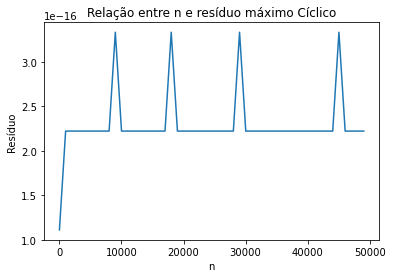

In [8]:
inicio = time.time()
tamanho_vetores = np.arange(n_min,n_max,step)
erroTridiagonalCiclicoVetorizado = np.vectorize(calculaResiduoParaGrafico)
residuos_cicl_maximos = erroTridiagonalCiclicoVetorizado(tamanho_vetores)
tempo = time.time() - inicio
print(f"Duração: {tempo} s")

#plotando o gráfico
fig, ax = plt.subplots()
ax.plot(tamanho_vetores, residuos_cicl_maximos)
ax.set_xlabel("n")
ax.set_ylabel("Resíduo")
plt.title("Relação entre n e resíduo máximo Cíclico")
plt.show()